# Diabetes in 130 US hospitals for the years 1999 to 2008

## Checking algorithms

 * [Feature selection](#Feature-selection)
   - [Correlation](#Correlation)
   - [Recursive feature elimination](#Recursive-feature-elimination)
 * [Logistic regression](#Logistic-regression)
   - [statsmodels](#statsmodels)
   - [scikit-learn](#scikit-learn)
     - [Confusion matrix](#Confusion-matrix)
     - [Precision, recall, F measure and support](#Precision,-recall,-F-measure-and-support)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
df_encoded = pd.read_csv('data/df_encoded.csv', index_col=0)

In [4]:
df_encoded.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,race=Caucasian,gender=Female,age=[10-20),max_glu_serum=None,A1Cresult=None,metformin=No,repaglinide=No,nateglinide=No,chlorpropamide=No,glimepiride=No,acetohexamide=No,glipizide=No,glyburide=No,tolbutamide=No,pioglitazone=No,rosiglitazone=No,acarbose=No,miglitol=No,troglitazone=No,tolazamide=No,examide=No,citoglipton=No,insulin=Up,glyburide-metformin=No,glipizide-metformin=No,glimepiride-pioglitazone=No,metformin-rosiglitazone=No,metformin-pioglitazone=No,change=Ch,diabetesMed=Yes,primary_diag=Others,secondary_diag=Diabetes,additional_diag=Others,race=AfricanAmerican,age=[20-30),glipizide=Steady,insulin=No,change=No,secondary_diag=Others,gender=Male,age=[30-40),additional_diag=Circulatory,age=[40-50),insulin=Steady,primary_diag=Neoplasms,secondary_diag=Neoplasms,age=[50-60),primary_diag=Circulatory,secondary_diag=Circulatory,age=[60-70),metformin=Steady,glimepiride=Steady,age=[70-80),glyburide=Steady,secondary_diag=Respiratory,age=[80-90),age=[90-100),rosiglitazone=Steady,additional_diag=Respiratory,primary_diag=Diabetes,additional_diag=Injury,glyburide=Up,additional_diag=Neoplasms,repaglinide=Up,insulin=Down,additional_diag=Diabetes,primary_diag=Respiratory,secondary_diag=Injury,additional_diag=Genitourinary,primary_diag=Injury,diabetesMed=No,secondary_diag=Musculoskeletal,race=Other,A1Cresult=>7,secondary_diag=Genitourinary,acarbose=Steady,primary_diag=Genitourinary,secondary_diag=Digestive,metformin=Up,additional_diag=Digestive,troglitazone=Steady,primary_diag=Musculoskeletal,primary_diag=Digestive,A1Cresult=>8,A1Cresult=Norm,repaglinide=Steady,additional_diag=Musculoskeletal,max_glu_serum=>300,glipizide=Up,max_glu_serum=Norm,max_glu_serum=>200,glipizide=Down,race=Asian,race=Hispanic,repaglinide=Down,age=[0-10),rosiglitazone=Up,glimepiride=Down,glimepiride=Up,tolazamide=Steady,pioglitazone=Steady,pioglitazone=Up,metformin=Down,glyburide=Down,tolbutamide=Steady,chlorpropamide=Steady,pioglitazone=Down,acarbose=Up,rosiglitazone=Down,glyburide-metformin=Steady,nateglinide=Steady,chlorpropamide=Down,chlorpropamide=Up,glyburide-metformin=Down,miglitol=Steady,glyburide-metformin=Up,nateglinide=Down,acetohexamide=Steady,miglitol=Down,nateglinide=Up,glipizide-metformin=Steady,miglitol=Up,metformin-pioglitazone=Steady
0,3,59,0,18,0,0,0,9,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2,11,5,13,2,0,1,6,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,2,44,1,16,0,0,0,7,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1,51,0,8,0,0,0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.

In [5]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68629 entries, 0 to 68628
Columns: 132 entries, time_in_hospital to metformin-pioglitazone=Steady
dtypes: float64(123), int64(9)
memory usage: 69.6 MB


In [6]:
df_encoded.shape

(68629, 132)

# Feature selection

We're going to first compute the _standard correlation coefficient_ (also known as the _Pearson's r_ coefficient) between all of the numerical features in the data set. This reveals the numerical features that are the most correlated with the `readmitted` dependent variable feature.

## Correlation

In [7]:
numeric_cols = df_encoded.select_dtypes('int64').columns
filter_ = df_encoded[numeric_cols].corr()['readmitted'] < 1
corr_matrix = df_encoded[numeric_cols].corr()['readmitted'][filter_].abs()
corr_matrix.sort_values(ascending=False, inplace=True)

In [8]:
corr_matrix.reset_index().rename(columns={'index': 'Feature', 'readmitted': 'Correlation'})

,Feature,Correlation
0,number_inpatient,0.140042
1,number_diagnoses,0.092481
2,number_emergency,0.074913
3,number_outpatient,0.061496
4,time_in_hospital,0.056052
5,num_lab_procedures,0.043653
6,num_medications,0.030383
7,num_procedures,0.029285


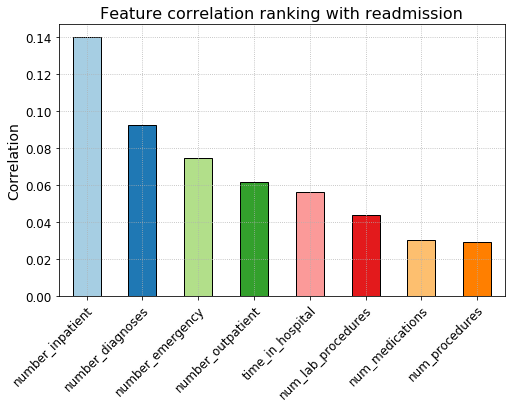

In [9]:
ax = corr_matrix.plot(kind='bar', color=plt.cm.Paired.colors, figsize=(8, 5), edgecolor='k')
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor", rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_title('Feature correlation ranking with readmission' , fontsize=16)
plt.grid(True, linestyle=':');

In [10]:
corr_columns = list(corr_matrix.index)

## Recursive feature elimination

We're going to perform [feature ranking with recursive feature elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), using the RFE class in scikit-learn. This procedure was taken from this blog post ['Building A Logistic Regression in Python, Step by Step'](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8). As the blog post mentions, this technique "is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features."

In [11]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [12]:
X = df_encoded.drop('readmitted', axis=1)
y = df_encoded.loc[:, 'readmitted'].values.ravel()
print(f'Dimensions of X: {X.shape}')
print(f'Dimensions of y: {y.shape}')

Dimensions of X: (68629, 131)
Dimensions of y: (68629,)


The `readmitted` output column has a fairly similar amount of readmission and non-readmission cases.

In [13]:
print(f'Ratio of readmission to total: {(y == 1).sum()/y.shape[0]:.2f}')
print(f'Ratio of non-readmission to total: {(y == 0).sum()/y.shape[0]:.2f}')

Ratio of readmission to total: 0.40
Ratio of non-readmission to total: 0.60


In [14]:
from time import time
t0 = time()
lg = LogisticRegression(solver='newton-cg')
rfe = RFE(lg, n_features_to_select=20)
rfe = rfe.fit(X, y)
print(f'Time elapsed: {time() - t0:.2f} sec.')

Time elapsed: 479.87 sec.


In [15]:
print(f'Number of reduced features: {rfe.n_features_}')
print(f'List of reduced features: {list(X.columns.values[rfe.support_])}')

Number of reduced features: 20
List of reduced features: ['number_inpatient', 'A1Cresult=None', 'nateglinide=No', 'chlorpropamide=No', 'troglitazone=No', 'examide=No', 'race=AfricanAmerican', 'secondary_diag=Neoplasms', 'glimepiride=Steady', 'age=[70-80)', 'glyburide=Steady', 'secondary_diag=Respiratory', 'acarbose=Steady', 'primary_diag=Musculoskeletal', 'primary_diag=Digestive', 'race=Asian', 'rosiglitazone=Up', 'tolbutamide=Steady', 'nateglinide=Up', 'metformin-pioglitazone=Steady']


In [16]:
X_mod = X.loc[:, list(X.columns.values[rfe.support_])]

In [17]:
print(X_mod.shape)
print(y.shape)

(68629, 20)
(68629,)


# Logistic regression

## statsmodels

We now determine the features that give the most significant contribution to our analysis.

In [18]:
import statsmodels.api as sm
logit_model = sm.Logit(y, X_mod)
result = logit_model.fit_regularized(method='l1')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6630438564590501
            Iterations: 185
            Function evaluations: 185
            Gradient evaluations: 185


In [19]:
print(result.summary2())

                                      Results: Logit
Model:                       Logit                    Pseudo R-squared:         0.017     
Dependent Variable:          y                        AIC:                      91048.0736
Date:                        2019-07-24 17:03         BIC:                      91230.8031
No. Observations:            68629                    Log-Likelihood:           -45504.   
Df Model:                    19                       LL-Null:                  -46306.   
Df Residuals:                68609                    LLR p-value:              0.0000    
Converged:                   1.0000                   Scale:                    1.0000    
No. Iterations:              185.0000                                                     
------------------------------------------------------------------------------------------
                               Coef.    Std.Err.     z     P>|z|     [0.025       0.975]  
-------------------------------------

There are 11 feature that have a p value greater than 0.05, and these are: `nateglinide=No`, `chlorpropamide=No`, `race=AfricanAmerican`, `secondary_diag=Neoplasms`, `glimepiride=Steady`, `age=[70-80)`, `glyburide=Steady`, `secondary_diag=Respiratory`, `primary_diag=Musculoskeletal`, `nateglinide=Up` and `metformin-pioglitazone=Steady`. We remove these column from the analysis.

In [20]:
removed_cols = ['nateglinide=No', 'chlorpropamide=No', 'race=AfricanAmerican', 'secondary_diag=Neoplasms', \
                'glimepiride=Steady', 'age=[70-80)', 'glyburide=Steady', 'secondary_diag=Respiratory', \
                'primary_diag=Musculoskeletal', 'nateglinide=Up', 'metformin-pioglitazone=Steady']

In [21]:
columns_to_keep = list(set(X_mod.columns) - set(removed_cols))
in_common = list(set(columns_to_keep) & set(corr_columns))[0]
print(f'Features in common between correlation and RFE procedures: {in_common}')
print(f'Final set of features to be used for analysis: {columns_to_keep}')
X_mod_after_rfe = X_mod[columns_to_keep]

Features in common between correlation and RFE procedures: number_inpatient
Final set of features to be used for analysis: ['rosiglitazone=Up', 'A1Cresult=None', 'acarbose=Steady', 'examide=No', 'number_inpatient', 'troglitazone=No', 'race=Asian', 'tolbutamide=Steady', 'primary_diag=Digestive']


In [22]:
logit_model_after_rfe = sm.Logit(y, X_mod_after_rfe)
result_after_rfe = logit_model_after_rfe.fit_regularized(method='l1')
print(result_after_rfe.summary2())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6631810126932653
            Iterations: 74
            Function evaluations: 74
            Gradient evaluations: 74
                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.017     
Dependent Variable:   y                  AIC:                91044.8994
Date:                 2019-07-24 17:03   BIC:                91127.1277
No. Observations:     68629              Log-Likelihood:     -45513.   
Df Model:             8                  LL-Null:            -46306.   
Df Residuals:         68620              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       74.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------

After the new feature set, there is still a feature called `acarbose=Steady` that has a high p value (`p=0.529`). We remove this feature as well.

In [23]:
removed_cols = removed_cols + ['acarbose=Steady']
columns_to_keep = list(set(X_mod.columns) - set(removed_cols))
print(f'Final set of features to be used for analysis: {columns_to_keep}')
X_mod_after_rfe_second = X_mod[columns_to_keep]

Final set of features to be used for analysis: ['rosiglitazone=Up', 'A1Cresult=None', 'number_inpatient', 'examide=No', 'troglitazone=No', 'race=Asian', 'tolbutamide=Steady', 'primary_diag=Digestive']


In [24]:
logit_model_after_rfe_second = sm.Logit(y, X_mod_after_rfe_second)
result_after_rfe_second = logit_model_after_rfe_second.fit_regularized(method='l1')
print(result_after_rfe_second.summary2())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6631839221813837
            Iterations: 63
            Function evaluations: 63
            Gradient evaluations: 63
                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.017     
Dependent Variable:   y                  AIC:                91043.2988
Date:                 2019-07-24 17:03   BIC:                91116.3906
No. Observations:     68629              Log-Likelihood:     -45514.   
Df Model:             7                  LL-Null:            -46306.   
Df Residuals:         68621              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       63.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------

## scikit-learn

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_mod_after_rfe_second, y, test_size = 0.2, random_state=42)

In [26]:
print(f'X_train: {X_train.shape}\nX_test: {X_test.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}')

X_train: (54903, 8)
X_test: (13726, 8)
y_train: (54903,)
y_test: (13726,)


In [27]:
lg = LogisticRegression(solver='newton-cg').fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(f'Accuracy of logistic regression classifier on test set: {lg.score(X_test, y_test):.3f}')

Accuracy of logistic regression classifier on test set: 0.623


### Confusion matrix

As explained in scikit-learn at ['sklearn.metrics.confusion_matrix'](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html):

 - a confusion matrix `C` is such that `C[i, j]` is equal to the number of observations known to be in group `i` but predicted to be in group `j`.

Thus in binary classification, the count of true negatives is `C[0, 0]`, false negatives is `C[1, 0]`, true positives is `C[1, 1]` and false positives is `C[0, 1]`.

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[7587  645]
 [4523  971]]


### Precision, recall, F-measure and support

As defined in scikit-learn at ['sklearn.metrics.precision_recall_fscore_support'](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html):

 - the precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

 - the recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

 - the `F-beta` score can be interpreted as a weighted harmonic mean of the precision and recall, where an `F-beta` score reaches its best value at 1 and worst score at 0.

 - the `F-beta` score weights the recall more than the precision by a factor of `beta`. `beta = 1.0` means recall and precision are equally important.

 - the support is the number of occurrences of each class in `y_test`.

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.92      0.75      8232
           1       0.60      0.18      0.27      5494

    accuracy                           0.62     13726
   macro avg       0.61      0.55      0.51     13726
weighted avg       0.62      0.62      0.56     13726

